In [2]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, SSMCMain.SpaceMMiCRM, MLSolver

Precompiling packages...
  13138.2 ms  ✓ SSMCMain
  1 dependency successfully precompiled in 18 seconds. 478 already precompiled.


In [3]:
using CairoMakie, ProgressLogging
using Base.Threads
using BenchmarkTools
using JLD2, Geppetto

In [5]:
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# ODE/PDE Solving

## Basic no space solve

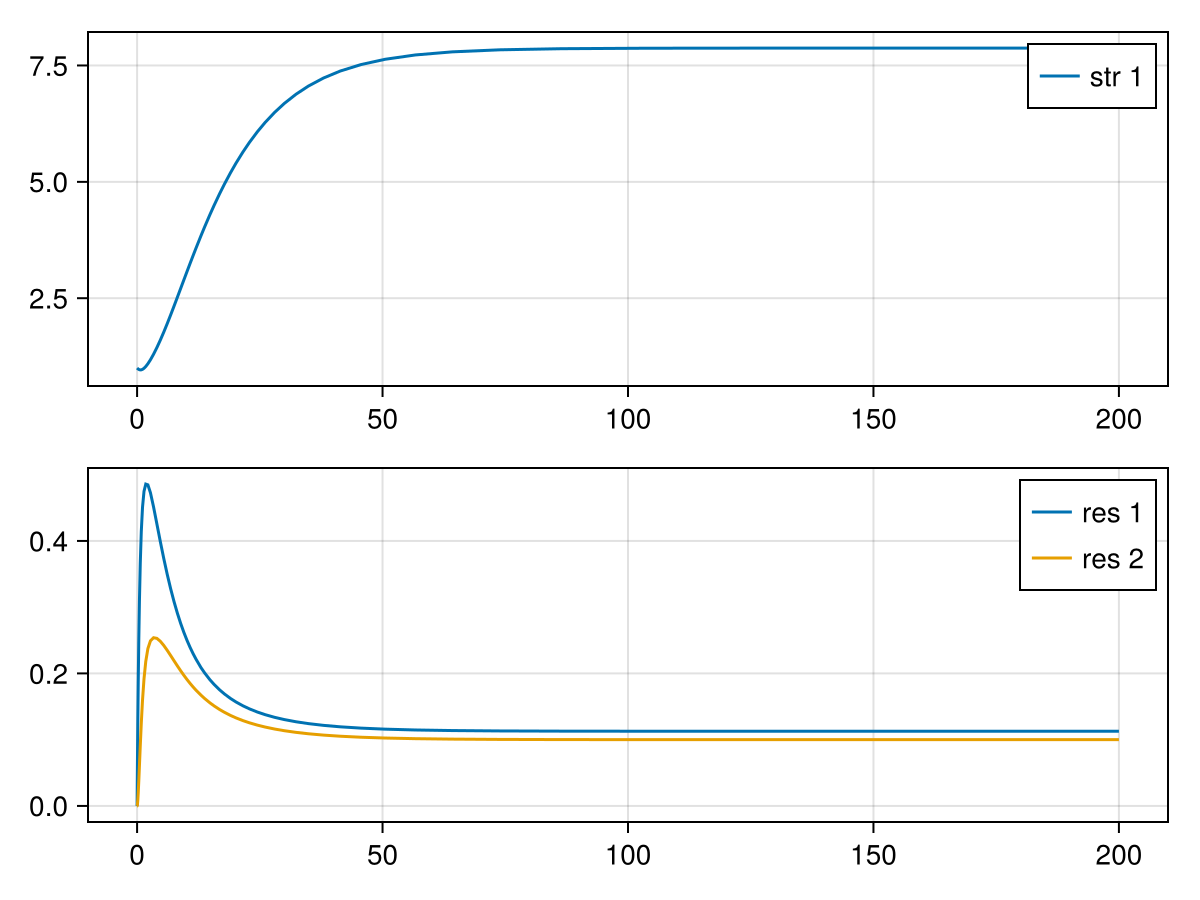

3-element Vector{Float64}:
 7.8729848580251485
 0.11270164600437772
 0.09999998483864031

In [4]:
D = fill(0., 1, 2, 2)
D[1, 2, 1] = 1.
c = [1. 1.]
l = [1. 0.]

p = make_mmicrm_smart(1, 2, 200;
    D, c, l,
    K=[1., 0.],
    r=[1., 1.],
    m=[0.1],
    u0=:onlyN,
    u0rand=0.
)
s = solve(p)
check_mmicrmparams(p.p)
display(plot_mmicrm_sol(s))
s[end]
#param_summary(p.p)

#### Steady state solving

In [732]:
symsol = symbolic_solve_ode_ml(p)

┌ Warning: Solve::ratnz: Solve was unable to solve the system with inexact coefficients.
│     The answer was obtained by solving a corresponding exact system and
│     numericizing the result.
└ @ MathLink ~/.julia/packages/MathLink/S39uA/src/eval.jl:16


3-element Vector{Vector{Pair{Num, Num}}}:
 [u1 => 0.0, u2 => 1.0, u3 => 0.0]
 [u1 => 0.12701665379258312, u2 => 0.8872983346207417, u3 => 0.1]
 [u1 => 7.872983346207417, u2 => 0.11270166537925831, u3 => 0.1]

In [733]:
sssol = solve(SteadyStateProblem(p), DynamicSS())
show(sssol)

[7.872887397594479, 0.1127028950432394, 0.1000009622883371]

## Linear stability analysis

In [5]:
usol = s.u[end]
show(uninplace(mmicrmfunc!)(usol, p.p, 0))

[-1.1936515530959768e-7, 1.5286459875696323e-9, 1.1909763175665944e-9]

maximum(real(lambdas)) = 0.0011651758922823774


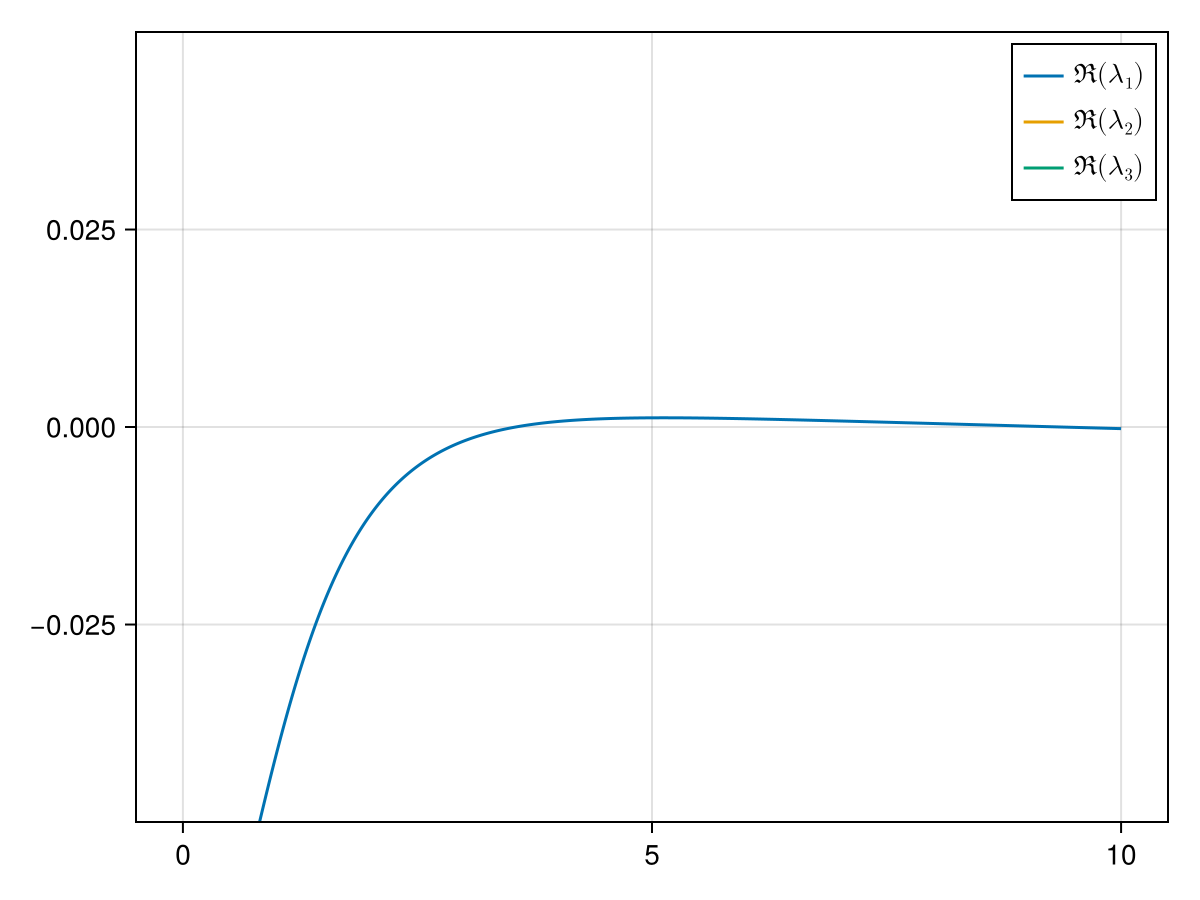

In [6]:
ks = LinRange(0., 10., 10000)
Ds = [1e-5, 5, 1]

lambdas = do_linstab_for_ks(ks, p, Ds, usol);
@show maximum(real(lambdas))
faa = plot_linstab_lambdas(ks, lambdas[:,:])
ylims!(faa.axis, (-0.05, 0.05))
# xlims!(faa.axis, (0., 2.))
faa

In [7]:
# Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax

(5124, 5.1235123512351235)

In [8]:
ff = linstab_make_full_func(p.p, usol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

3-element Vector{Float64}:
  0.9999996601185887
 -0.0008042873715794372
  0.00018134092498283248

## Spatial stuff - 1D!

In [11]:
ssize = (1000,)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.01, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 10000000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((3, 1000), 18, CartesianSpace{1, Tuple{Periodic}, Float64}([0.01]))

#### Direct solver

In [12]:
@time sps = solve(sp, QNDF(); maxiters=1000)
display(sps.retcode)
display(sps.destats.nf)
@show length(sps.u)

  0.985603 seconds (347.46 k allocations: 401.133 MiB, 5.78% gc time)


ReturnCode.Success = 1

1648

length(sps.u) = 286


286

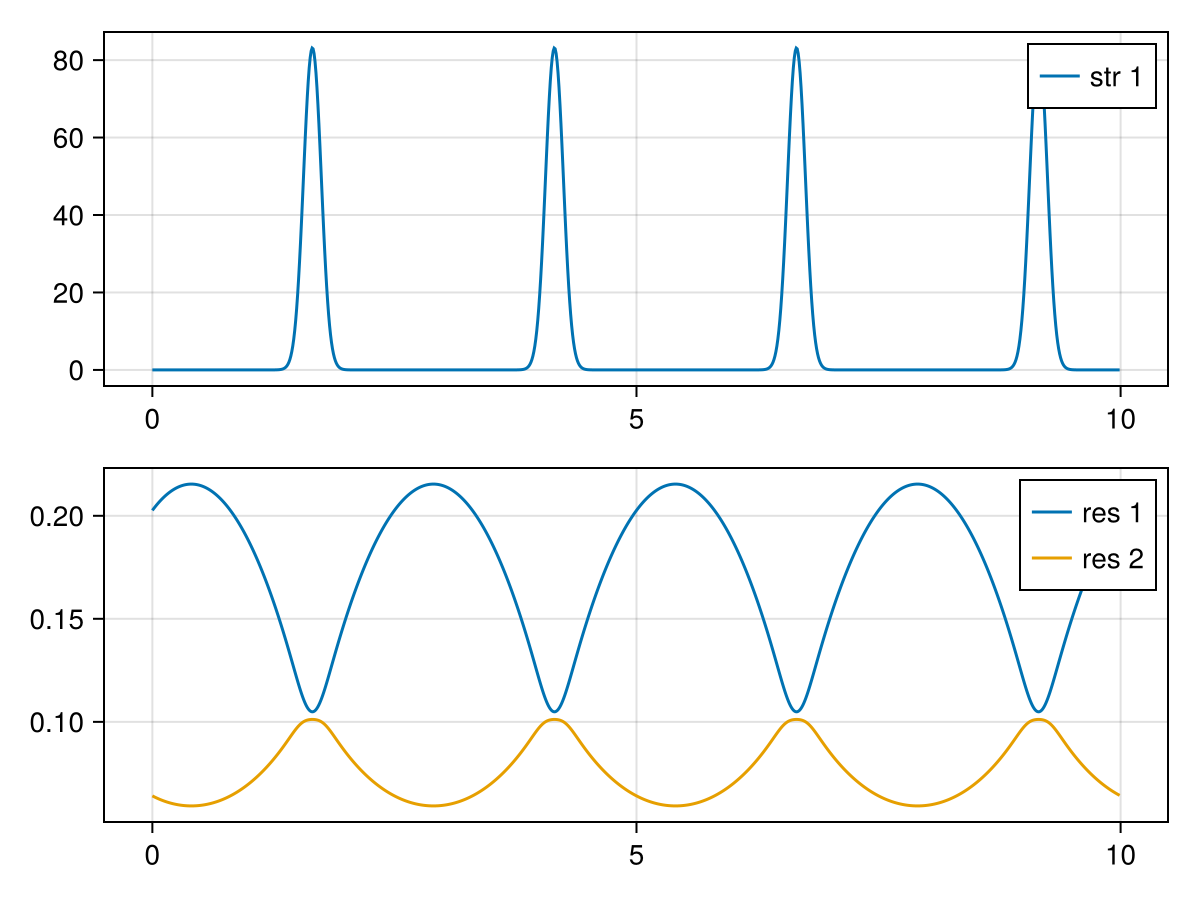

In [13]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps(sps.t[end]))

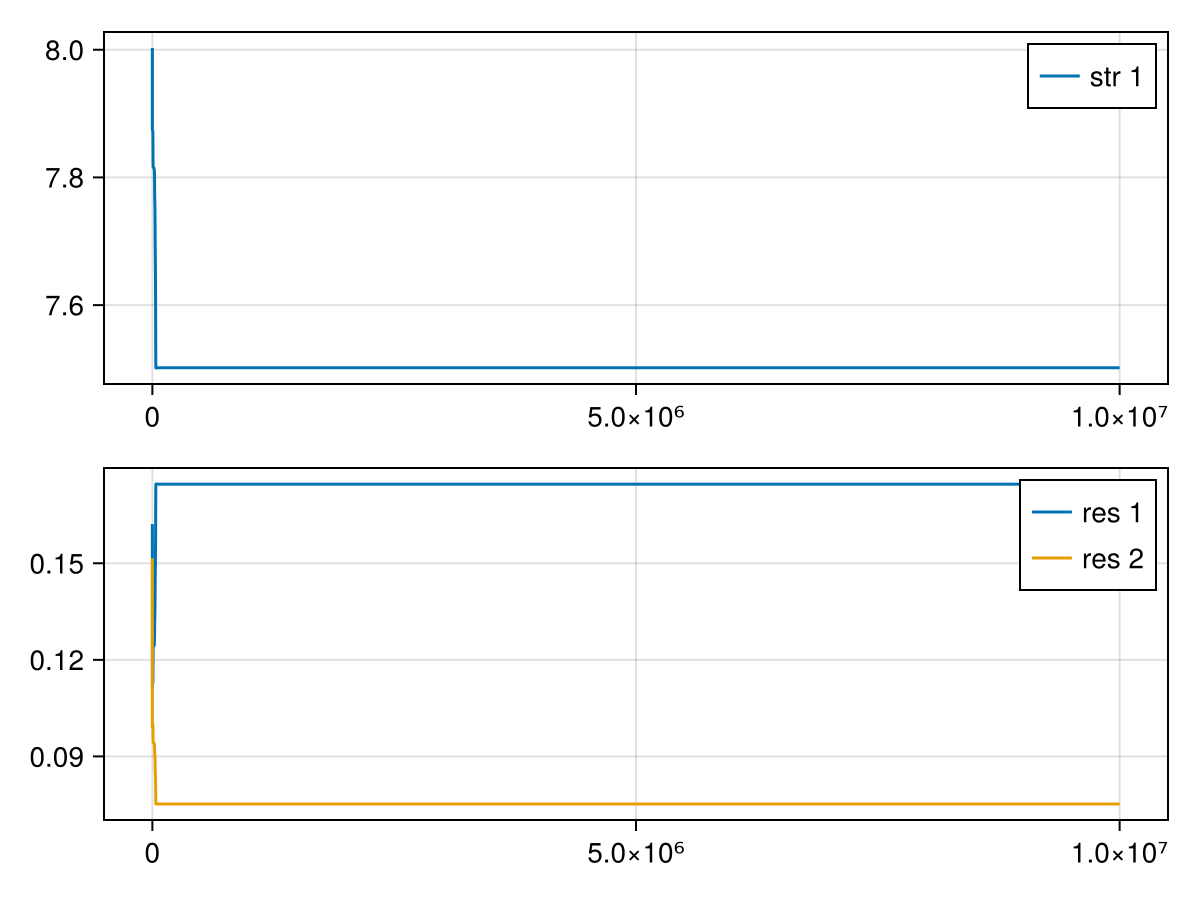

In [14]:
plot_smmicrm_sol_avgs(sps)

#### Steady state solver

 12.204321 seconds (836.84 k allocations: 2.199 GiB, 1.90% gc time)


ReturnCode.Success = 1

2803

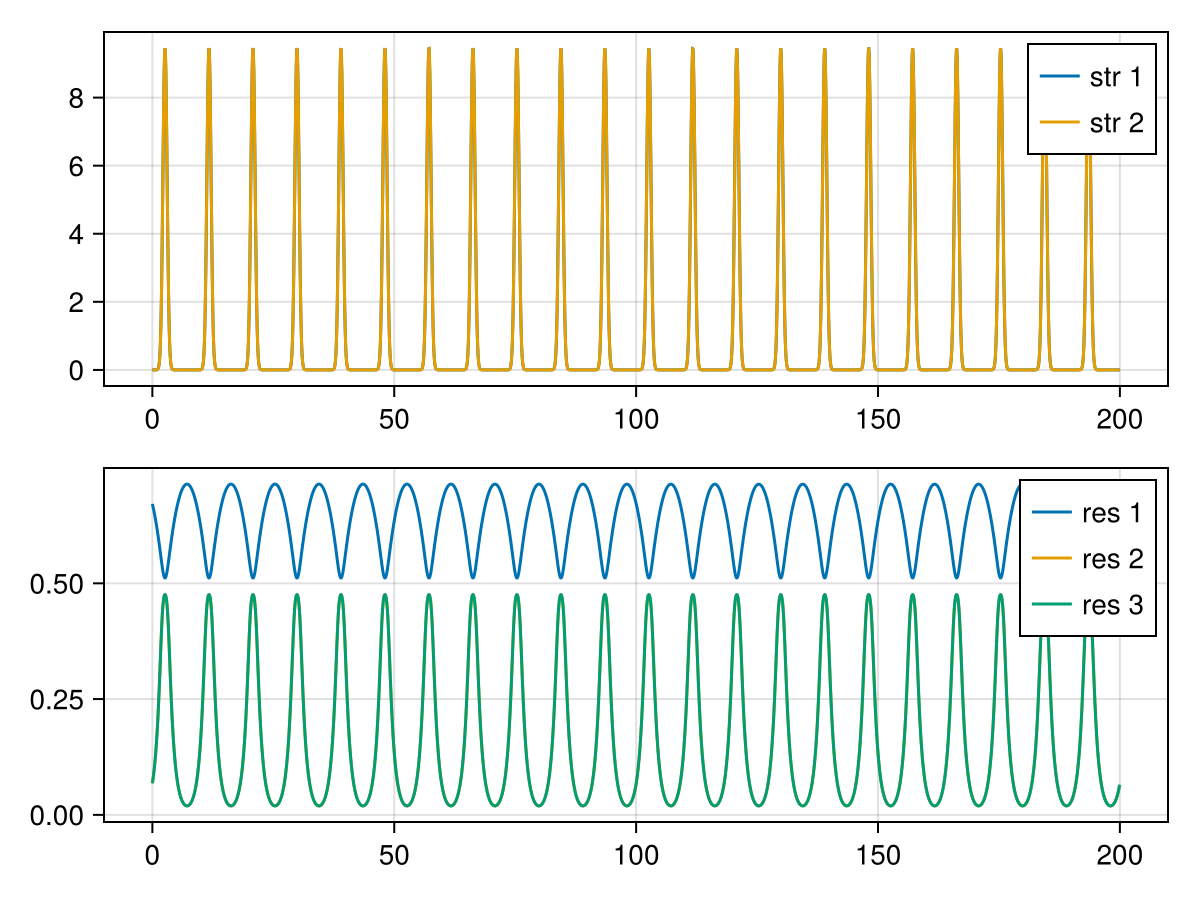

In [87]:
sssp = SteadyStateProblem(sp)
@time sssps = solve(sssp, DynamicSS(QNDF()); maxiters=1000)
display(sssps.retcode)
display(sssps.original.destats.nf)
plot_1dsmmicrm_sol_snap(sssps.prob.p, sssps.u)

## Spatial stuff - 2D!

In [46]:
ssize = (60,60)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.02, 0.02)
space = make_cartesianspace_smart(length(ssize); dx=0.1, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 100000000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((3, 60, 60), 18, CartesianSpace{2, Tuple{Periodic, Periodic}, Float64}([0.1, 0.1]))

#### Direct solver

In [47]:
@time sps = solve(sp, QNDF(); maxiters=10000)
print_spatial_solution_stats(sps)

 47.779911 seconds (857.03 k allocations: 7.153 GiB, 0.25% gc time)
Success
nf is 4367
solution has 427 saved states
max resid is 0.0001072


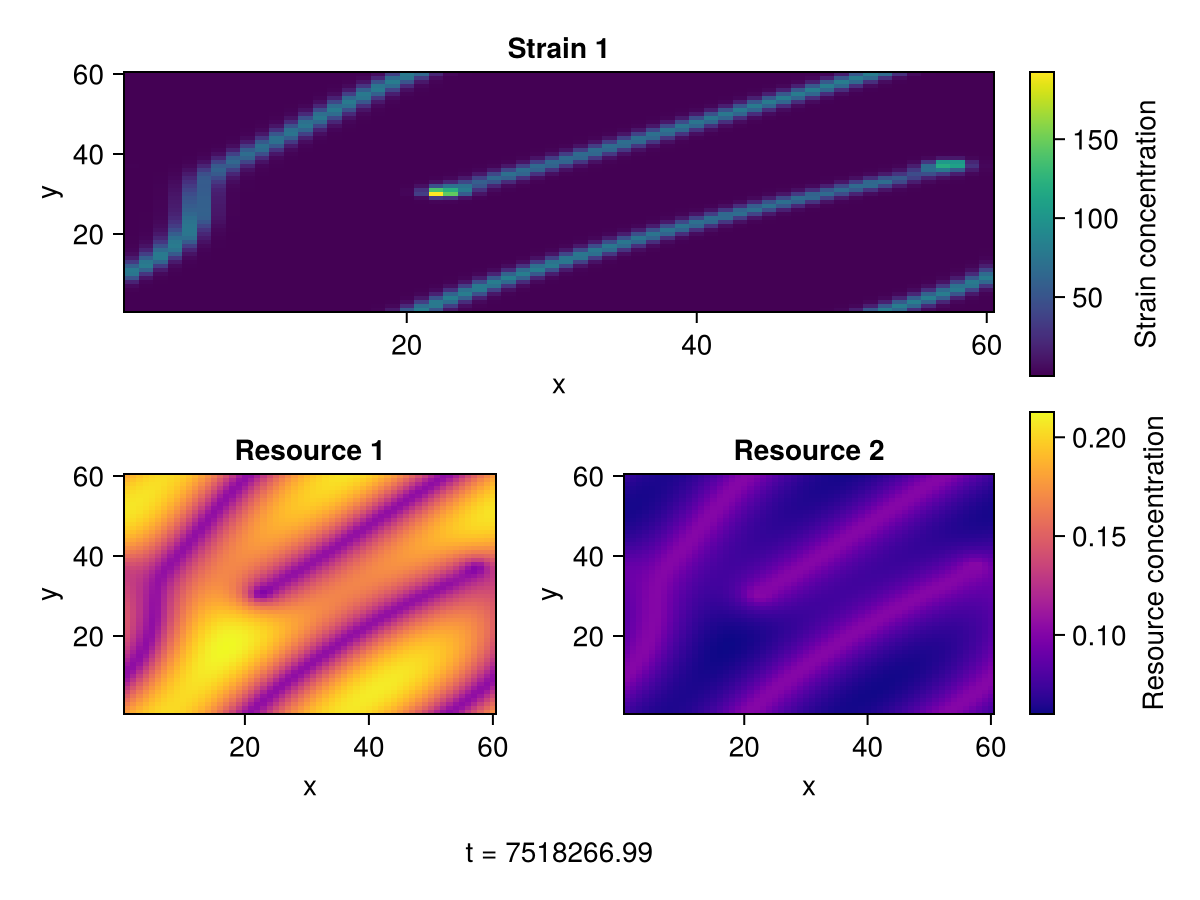

In [62]:
f = plot_2dsmmicrm_sol_snap_heatmap(sps, -1)

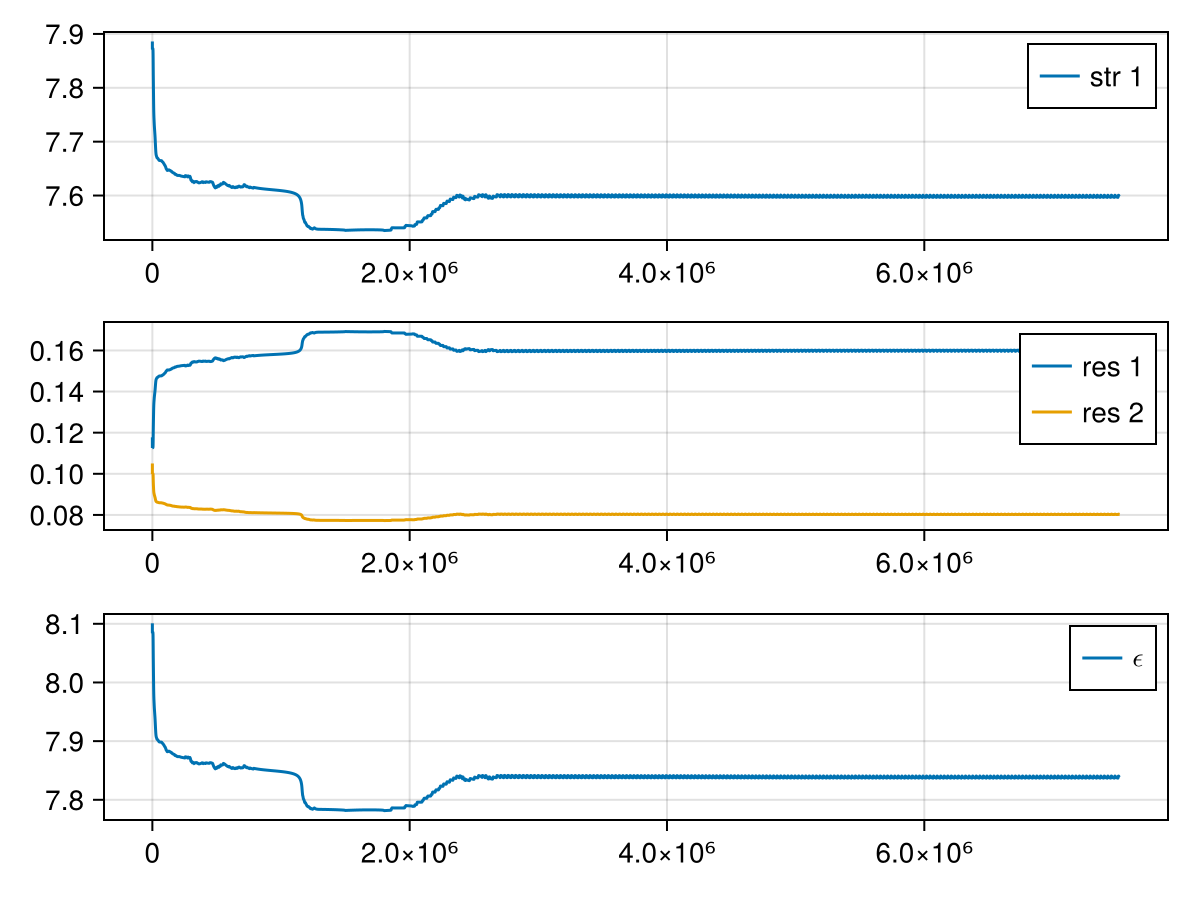

In [69]:
f = plot_smmicrm_sol_avgs(sps; plote=true)
#display(GLMakie.Screen(), f)

In [69]:
f = plot_2dsmmicrm_sol_interactive_heatmap(sps)
display(GLMakie.Screen(), f)

GLMakie.Screen(...)

#### Saving/loading

In [61]:
save_object(datadir("minimalmodel", randname()*".jld2"), sps)

In [6]:
sps = load_object("../data/minimalmodel/fascinating_maybe_moving.jld2");
print_spatial_solution_stats(sps)

MaxIters
nf is 110126
solution has 8608 saved states
max resid is 0.00431203


# Symbolics

In [72]:
using Symbolics, SymbolicsMathLink

In [73]:
pvars = @variables m l K r c d
fvars = @variables N G R
ssvars = @variables N_ss G_ss R_ss
Dvars = @variables D_N D_G D_R
@variables k;

In [74]:
sym_params = MMiCRMParams(
    Num.(p.p.g), Num.(p.p.w),
    SA[m],
    SA[K, 0.], SA[r, r],
    SA[l 0], SA[c d], Num.(p.p.D)
)
u = SA[N, G, R]
eqs = uninplace(mmicrmfunc!)(u, sym_params)

3-element SizedVector{3, Num, Vector{Num}} with indices SOneTo(3):
 (-m + R*d + G*c*(1.0 - l))*N
              K - G*r - G*N*c
       -R*r - N*R*d + G*N*c*l

#### With analytic ss

In [554]:
symsol = wcall("Solve", Vector(eqs .~ 0.), fvars);
[[(y[1],iszero(y[2])) for y in x] for x in symsol]

┌ Warning: Solve::ratnz: Solve was unable to solve the system with inexact coefficients.
│     The answer was obtained by solving a corresponding exact system and
│     numericizing the result.
└ @ MathLink ~/.julia/packages/MathLink/S39uA/src/eval.jl:16


3-element Vector{Vector{Tuple{Num, Bool}}}:
 [(N, 0), (G, 0), (R, 0)]
 [(N, 0), (G, 0), (R, 0)]
 [(N, 1), (G, 0), (R, 1)]

In [555]:
syms1 = wcall("FullSimplify", [x[2] for x in symsol[1]])
display(syms1)
syms2 = wcall("FullSimplify", [x[2] for x in symsol[2]])
display(syms2);

3-element Vector{Num}:
   ((-0.5(d^2) + (c^2)*(0.5 - 0.5l) - 0.5000000000000001c*d*l)*r) / (c*(-c + d + c*l)*d) + (0.5K) / m + (0.5(((-K*c*d + c*m*r - d*m*r)^2 - 4.0K*c*(d + c*(-1.0 + l))*d*m*r)^(1//2))) / (c*d*m)
                                                             (-0.5(-K*c*d + c*m*r - d*m*r + ((-K*c*d + c*m*r - d*m*r)^2 - 4.0K*c*(d + c*(-1.0 + l))*d*m*r)^(1//2))) / (c*(d + c*(-1.0 + l))*r)
 (-0.5((K*d + m*r)*c*(1.0 - l) + d*(-1.0 - l)*m*r + (((K^2)*(c^2)*(d^2) + (c^2 - 2.0c*d + d^2)*(m^2)*(r^2) + K*c*(2.0c - 2.0d - 4.0c*l)*d*m*r)^(1//2))*(-1.0 + l))) / ((d + c*(-1.0 + l))*d*r)

3-element Vector{Num}:
 ((-0.5(d^2) + (c^2)*(0.5 - 0.5l) - 0.5000000000000001c*d*l)*r) / (c*(-c + d + c*l)*d) + (0.5K) / m + (-0.5(((-K*c*d + c*m*r - d*m*r)^2 - 4.0K*c*(d + c*(-1.0 + l))*d*m*r)^(1//2))) / (c*d*m)
                                                              (0.5(K*c*d - c*m*r + d*m*r + ((-K*c*d + c*m*r - d*m*r)^2 - 4.0K*c*(d + c*(-1.0 + l))*d*m*r)^(1//2))) / (c*(d + c*(-1.0 + l))*r)
 (0.5((K*d + m*r)*c*(-1.0 + l) + d*(1.0 + l)*m*r + (((K^2)*(c^2)*(d^2) + (c^2 - 2.0c*d + d^2)*(m^2)*(r^2) + K*c*(2.0c - 2.0d - 4.0c*l)*d*m*r)^(1//2))*(-1.0 + l))) / ((d + c*(-1.0 + l))*d*r)

In [565]:
symM = make_M(sym_params, k, syms1, Dvars)

3×3 Matrix{Num}:
 -m + (-0.5((K*d + m*r)*c*(1.0 - l) + d*(-1.0 - l)*m*r + (((K^2)*(c^2)*(d^2) + (c^2 - 2.0c*d + d^2)*(m^2)*(r^2) + K*c*(2.0c - 2.0d - 4.0c*l)*d*m*r)^(1//2))*(-1.0 + l))) / ((d + c*(-1.0 + l))*r) + (-0.5(-K*c*d + c*m*r - d*m*r + ((-K*c*d + c*m*r - d*m*r)^2 - 4.0K*c*(d + c*(-1.0 + l))*d*m*r)^(1//2))*(1 - l)) / ((d + c*(-1.0 + l))*r) - D*(k^2)  …                 d*(((-0.5(d^2) + (c^2)*(0.5 - 0.5l) - 0.5c*d*l)*r) / (c*(-c + d + c*l)*d) + (0.5K) / m + (0.5(((-K*c*d + c*m*r - d*m*r)^2 - 4.0K*c*(d + c*(-1.0 + l))*d*m*r)^(1//2))) / (c*d*m))
                                                                                                                                                                                                                   -((-0.5(-K*c*d + c*m*r - d*m*r + ((-K*c*d + c*m*r - d*m*r)^2 - 4.0K*c*(d + c*(-1.0 + l))*d*m*r)^(1//2))) / ((d + c*(-1.0 + l))*r))                                                                                                        

In [603]:
e = SymbolicsMathLink.expr_to_mathematica(symM)
f = open(datadir("me_temp1"), "w")
write(f, string(e))
close(f)

In [615]:
export_expr_to_wolfram(e, datadir(randname()))

#### With fake ss sol

In [75]:
symM = make_M(sym_params, k, ssvars, Dvars)

3×3 Matrix{Num}:
 -m + R_ss*d - D_N*(k^2) + G_ss*c*(1 - l)  …                   N_ss*d
                                  -G_ss*c                         0.0
                       -R_ss*d + G_ss*c*l     -r - N_ss*d - D_R*(k^2)

In [76]:
export_expr_to_wolfram(symM, datadir(randname()))

In [629]:
wcall("Eigenvalues", symM)

var"\$Aborted"

# Extras

In [952]:
GC.gc()
empty!(Out)

Dict{Int64, Any}()